In [0]:
from sklearn import datasets
import numpy as np
import random
import matplotlib.pyplot as plt
import tqdm
import itertools

In [0]:
from keras.layers import Dense, Input
import tensorflow as tf
from keras.models import Model
from keras import backend as K
import keras

([], <a list of 0 Text yticklabel objects>)

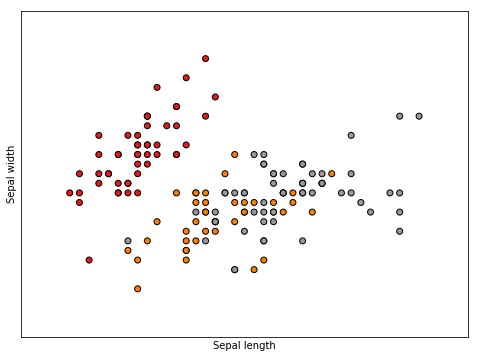

In [5]:
from mpl_toolkits.mplot3d import Axes3D
from sklearn import datasets
from sklearn.decomposition import PCA
iris = datasets.load_iris()
X = iris.data[:, :2]  # we only take the first two features.
y = iris.target
x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
plt.figure(2, figsize=(8, 6))
plt.clf()
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Set1,edgecolor='k')
plt.xlabel('Sepal length')
plt.ylabel('Sepal width')
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())

In [0]:
iris = datasets.load_iris()
X = iris.data
y = iris.target

In [7]:
X.shape

(150, 4)

In [8]:
y

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

In [0]:
def create_model():
  i=Input(shape=(X.shape[1],))
  d=Dense(20,activation="relu")(i)
  d=Dense(1,activation="sigmoid")(d)
  return Model(inputs=i,outputs=d)

def fit_model(xx,yy,model,validation,verbose=0,epochs=10,loss="binary_crossentropy"):
  model.compile(optimizer="adam",loss=loss,metrics=["acc"])
  history=model.fit(xx,yy,batch_size=10,epochs=epochs,verbose=verbose,validation_data=validation)
  return model,history

## Create 2 tasks: 
####A 'setosa' -1 , 'versicolor' - 0
####B 'virginica' -1, 'versicolor' - 0

In [0]:
yA=y[np.where((y==1) | (y==0))]
XA=X[np.where((y==1) | (y==0))]

In [0]:
yB=2 - y[np.where((y==1) | (y==2))]
XB=X[np.where((y==1) | (y==2))]

## Catastrophic Forgetting

In [0]:
model = create_model()
model,historyA=fit_model(XA,yA,model,[XA,yA],epochs=50)

1.0

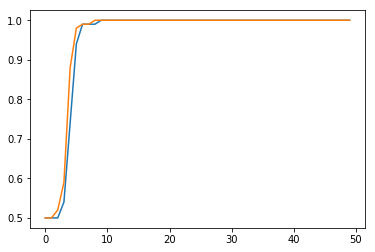

In [215]:
plt.plot(historyA.history["acc"])
plt.plot(historyA.history["val_acc"])
model.evaluate(XA,yA,verbose=0)[1]

(0.97, 0.47, 0.95)

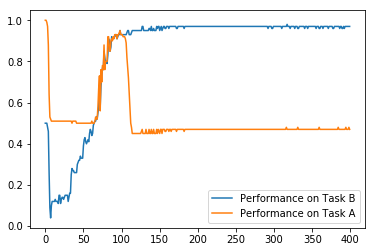

In [216]:
model,historyB=fit_model(XB,yB,model,[XA,yA],epochs=400)
plt.plot(historyB.history["acc"],label='Performance on Task B')
plt.plot(historyB.history["val_acc"],label='Performance on Task A')
plt.legend()
model.evaluate(XB,yB,verbose=0)[1],model.evaluate(XA,yA,verbose=0)[1],max(historyB.history["val_acc"][10:])

## EWC

1.0

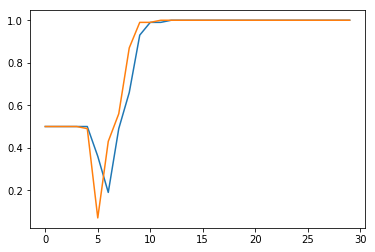

In [231]:
model = create_model()
model,historyA=fit_model(XA,yA,model,[XA,yA],epochs=30)
plt.plot(historyA.history["acc"])
plt.plot(historyA.history["val_acc"])
model.evaluate(XA,yA,verbose=0)[1]

In [0]:
def get_gradients(model):
    #get the gradients of the loss with respect to the weights. https://github.com/keras-team/keras/issues/2226
    weights = [tensor for tensor in model.trainable_weights if model.get_layer(tensor.name[:-2]).trainable]
    optimizer = model.optimizer
    return optimizer.get_gradients(model.total_loss, weights)

weights = model.trainable_weights # weight tensors
gradients = model.optimizer.get_gradients(model.total_loss, weights) # gradient tensors
input_tensors = model.inputs + model.sample_weights + model.targets + [K.learning_phase()]
get_gradients = K.function(inputs=input_tensors, outputs=gradients)
inputsA = [XA,np.ones(len(XA)), yA, 0]
gradsA = get_gradients(inputsA)
weightsA = model.get_weights()

In [0]:
def custom_loss(weights,weightsA,gradientsA):
    # Create a loss function that adds the MSE loss to the mean of all squared activations of a specific layer
    reg_term=0
    λ=10000000
    for i,_ in enumerate(weights):
      reg_term=reg_term+K.sum(K.square(gradientsA[i])*(K.square(weights[i]-weightsA[i])))
      assert weights[i].shape == gradientsA[i].shape and gradientsA[i].shape==weightsA[i].shape
      #print(_.shape)
    def loss(y_true,y_pred):
        return K.mean(-K.log(y_pred)*y_true - (1-y_true)*K.log(1-y_pred)) + λ*reg_term
    return loss

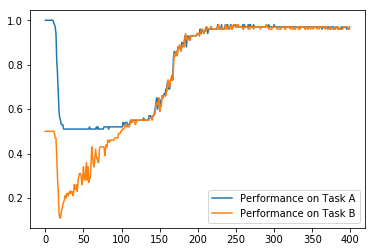

In [234]:
model,historyB=fit_model(XB,yB,model,[XA,yA],epochs=400,loss=custom_loss(weights,weightsA,gradsA))
plt.plot(historyB.history["val_acc"],label='Performance on Task A')
plt.plot(historyB.history["acc"], label='Performance on Task B')
plt.legend()

In [235]:
model.evaluate(XB,yB,verbose=0)[1],model.evaluate(XA,yA,verbose=0)[1]

(0.97, 0.97)

##### Training 1 epoch at a time (slow)

In [95]:
epoques=50
Bperform=[]
Aperform=[]
for i in tqdm.tqdm_notebook(np.arange(epoques)):
  model,historyB=fit_model(XB,yB,model,epochs=1,loss=custom_loss(weights,weightsA,gradsA))
  Bperform.append(model.evaluate(XB,yB,verbose=0)[1])
  Aperform.append(model.evaluate(XA,yA,verbose=0)[1])
plt.plot(Aperform,label='Performance on Task A')
plt.plot(Bperform, label='Performance on Task B')
plt.legend()

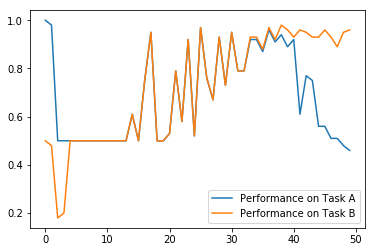

#### Rough

In [163]:
dense_weights[:1]

[<tf.Variable 'dense_47/kernel:0' shape=(4, 20) dtype=float32_ref>]

In [164]:
np.sum(np.square(model.get_weights()[0])),np.sum(np.square(model.get_weights()[1])),np.sum(np.square(model.get_weights()[2])),np.sum(np.square(model.get_weights()[3]))

(0.0008206764, 2.342258e-06, 0.003751343, 2.76951e-07)

In [165]:
model.get_weights()[1]

array([-1.5468022e-04,  0.0000000e+00, -3.3053698e-04,  3.5320903e-05,
       -3.7794712e-04, -4.5757602e-05,  0.0000000e+00,  5.0893833e-04,
        4.0277460e-04, -4.8337050e-04,  0.0000000e+00,  3.9791461e-04,
       -5.0690741e-04, -3.2024371e-04, -2.4446843e-05,  5.8065751e-04,
       -4.5855273e-04,  0.0000000e+00, -4.7312927e-04, -3.4390355e-04],
      dtype=float32)

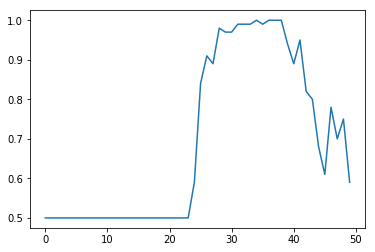

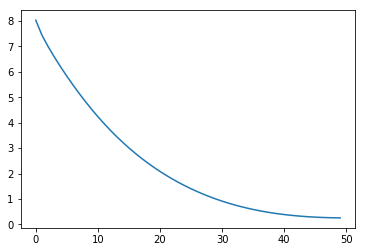

In [166]:
plt.plot(history.history["acc"])
plt.show()
plt.plot(history.history["loss"])


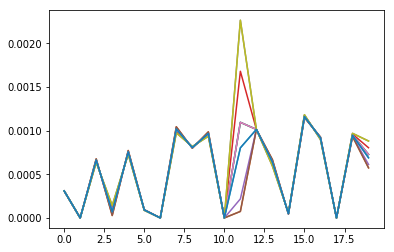

In [252]:
n_s=50
for i in np.arange(10):
  indices=np.random.choice(np.arange(100),n_s)
  inputs = [XA[list(indices)],np.ones(len(XA[:n_s])),yA[list(indices)], 0]
  grads1 = get_gradients(inputs)
  #plt.plot(np.absolute(grads[1]))
  plt.plot(np.absolute(grads1[1]))

inputs = [XA,np.ones(len(XA)), yA, 0]
grads1 = get_gradients(inputs)
plt.plot(np.absolute(grads1[1]))
